<a href="https://colab.research.google.com/github/Tarnished2/DataScientist/blob/main/MachineLearning/16.ClusteringRFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pramaditya Ardian Saputra

Gunakan data scanner_data.csv untuk RFM Analysis!

In [ ]:
# connect colab ke g drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn .preprocessing import MinMaxScaler
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Membuat path untuk mengidentifikasi letak directory
path = '/content/gdrive/MyDrive/SIB/6. Supervised Machine Learning - Clustering/6.2 Clustering - RFM/'

# Cek directory
os.listdir(path)

['data_RFM.csv',
 'data_RFM.xlsx',
 'scanner_data.csv',
 'K_Means_Customer_Segmentation.ipynb',
 'Exercise 16_Muklis_Pramaditya Ardian Saputra.ipynb']

In [ ]:
# Load data
df = pd.read_csv(os.path.join(path, "scanner_data.csv"))

In [ ]:
df.tail()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57
131705,131706,04/07/2016,20203,32900,Q4N,QM9BP,1.0,13.68


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


Apakah terdapat missing value dalam data?

In [ ]:
df.isnull().sum()

Unnamed: 0        0
Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

Apakah ada data yang minus? Gunakan data yang bernilai positif untuk analysis ya!

In [ ]:
df1= df[(df.Quantity > 0) & (df.Sales_Amount >= 0)]
print(df1.describe())

          Unnamed: 0    Customer_ID  Transaction_ID       Quantity  \
count  131706.000000  131706.000000   131706.000000  131706.000000   
mean    65853.500000   12386.450367    32389.604187       1.485311   
std     38020.391614    6086.447552    18709.901238       3.872667   
min         1.000000       1.000000        1.000000       0.010000   
25%     32927.250000    7349.000000    16134.000000       1.000000   
50%     65853.500000   13496.000000    32620.000000       1.000000   
75%     98779.750000   17306.000000    48548.000000       1.000000   
max    131706.000000   22625.000000    64682.000000     400.000000   

        Sales_Amount  
count  131706.000000  
mean       11.981524  
std        19.359699  
min         0.020000  
25%         4.230000  
50%         6.920000  
75%        12.330000  
max       707.730000  


In [ ]:
df1.shape

(131706, 8)

Data yang digunakan untuk pengolahan selanjutnya haruslah data yang benar positif sehingga mencerminkan proses transaksi yang dilakukan.

Hilangkan kolom No!

In [ ]:
df2 = df1.drop('Unnamed: 0', axis=1)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 8.0+ MB


Lakukan eksplor data experiment mengenai jumlah transaksi, banyaknya produk dan jumlah customer yang ada!

In [ ]:
#Melihat jumlah produk, jumlah transaksi, dan pelanggan
cust_x_prod = pd.DataFrame([{'products':len(df2['SKU'].value_counts()),
'transactions': len(df2['Transaction_ID'].value_counts()),
'customers': len(df2['Customer_ID'].value_counts()),}],
columns = ['products', 'transactions', 'customers'], index = ['quantity'])
print(cust_x_prod)

          products  transactions  customers
quantity      5242         64682      22625


Apakah kolom data sudah memiliki tipe data yang sesuai? Jika belum, ubahlah dulu tipe datanya agar sesuai.

In [ ]:
print(df2.dtypes)

Date               object
Customer_ID         int64
Transaction_ID      int64
SKU_Category       object
SKU                object
Quantity          float64
Sales_Amount      float64
dtype: object


In [ ]:
# Mengubah tipe data kolom 'Date' menjadi datetime64
df2['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Mengubah tipe data kolom 'SKU_Category' dan 'SKU' menjadi category
df2['SKU_Category'] = df2['SKU_Category'].astype('category')
df2['SKU'] = df2['SKU'].astype('category')

In [ ]:
print(df2.dtypes)

Date              datetime64[ns]
Customer_ID                int64
Transaction_ID             int64
SKU_Category            category
SKU                     category
Quantity                 float64
Sales_Amount             float64
dtype: object


Kapan terakhir ada transaksi?

In [ ]:
df2['Date'].max()

Timestamp('2016-12-31 00:00:00')

In [ ]:
df2.tail()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
131701,2016-04-07,20203,32900,IEV,FO112,3.0,6.46
131702,2016-04-07,20203,32900,N8U,I36F2,1.0,4.50
131703,2016-04-07,20203,32900,U5F,4X8P4,1.0,5.19
131704,2016-04-07,20203,32900,0H2,ZVTO4,1.0,4.57
131705,2016-04-07,20203,32900,Q4N,QM9BP,1.0,13.68


In [ ]:
#ambil data paling terakhir transaksi
now = dt.date(2016,12,31)

In [ ]:
df2['Date'] = pd.DatetimeIndex(df2.Date).date

Lakukan RFM Analysis!
Bagaimana recency pelanggan?

In [ ]:
#Group by berdasarkan customer terakhir membeli

recency_df = df2.groupby(['Customer_ID'],as_index=False)['Date'].max()
recency_df.columns = ['Customer_ID','LastPurchaseDate']
recency_df.head()

,Customer_ID,LastPurchaseDate
0,1,2016-01-22
1,2,2016-06-19
2,3,2016-02-01
3,4,2016-11-07
4,5,2016-09-02


In [ ]:
#hitung seberapa sering dia membeli dengan mengacu pada tanggal terbaru dalam beberapa hari

recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x: (now - x).days)
recency_df.head()

,Customer_ID,LastPurchaseDate,Recency
0,1,2016-01-22,344
1,2,2016-06-19,195
2,3,2016-02-01,334
3,4,2016-11-07,54
4,5,2016-09-02,120


Bagaimana frequency pelanggan?

In [ ]:
#periksa frekuensi pelanggan berarti sudah berapa kali transaksi

frequency_df = df2.copy()
frequency_df.drop_duplicates(subset=['Customer_ID','Transaction_ID'], keep="first", inplace=True)
frequency_df = frequency_df.groupby('Customer_ID',as_index=False)['Transaction_ID'].count()
frequency_df.columns = ['Customer_ID','Frequency']
frequency_df.head()

,Customer_ID,Frequency
0,1,1
1,2,2
2,3,1
3,4,2
4,5,5


Bagaimana monetary pelanggan?

In [ ]:
df2['Total_cost'] = df1['Sales_Amount'] * df1['Quantity']

In [ ]:
monetary_df=df2.groupby('Customer_ID',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['Customer_ID','Monetary']
monetary_df.head()

,Customer_ID,Monetary
0,1,16.29
1,2,22.77
2,3,19.08
3,4,33.29
4,5,248.27


Gabungkan recency, frequency dan monetary pelanggan dalam satu tabel!

In [ ]:
#combine first recency and frequency
rf = recency_df.merge(frequency_df,left_on='Customer_ID',right_on='Customer_ID')

#combibe rf frame with monetary values
rfm = rf.merge(monetary_df,left_on='Customer_ID',right_on='Customer_ID')
rfm.set_index('Customer_ID',inplace=True)
rfm.head()

,LastPurchaseDate,Recency,Frequency,Monetary
Customer_ID,,,,
1,2016-01-22,344,1,16.29
2,2016-06-19,195,2,22.77
3,2016-02-01,334,1,19.08
4,2016-11-07,54,2,33.29
5,2016-09-02,120,5,248.27


In [ ]:
rfm.drop(columns=['LastPurchaseDate'],inplace=True)
rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
1,344,1,16.29
2,195,2,22.77
3,334,1,19.08
4,54,2,33.29
5,120,5,248.27


Recency ditemukan dari perbedaan tanggal terbaru terhadap tanggal terakhir dalam data transaksi. hal ini menunjukkan range waktu yang disebut sebagai recency. Recency yang tinggi akan menjelaskan bahwa pembeli sudah lama sekali tidak bertransaksi dan sebaliknya.

Sedangkan Frequency ditemukan dari perhitungan jumlah InvoiceNo, dimana setiap CustomerID dapat melakukan beberapa transaksi yang akan mengkalkulasikan InvoiceNo.

Sementara Monetary merupakan jumlah pengeluaran uang oleh pelanggan dengan cara mengkalikan quantity terhadap price. Idealnya pelanggan terbaik itu mencerminkan nilai recency yang rendah tetapi nilai frequency dan monetary yang tinggi.

Buatlah pengunaan klasifikasi quartile untuk menentukan limit dari setiap klasifikasinya!

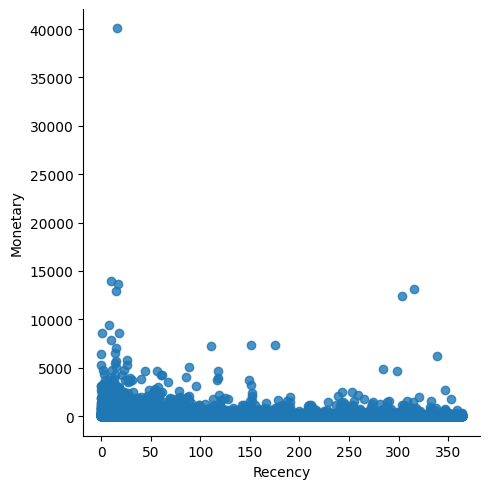

In [ ]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=rfm,fit_reg=True)

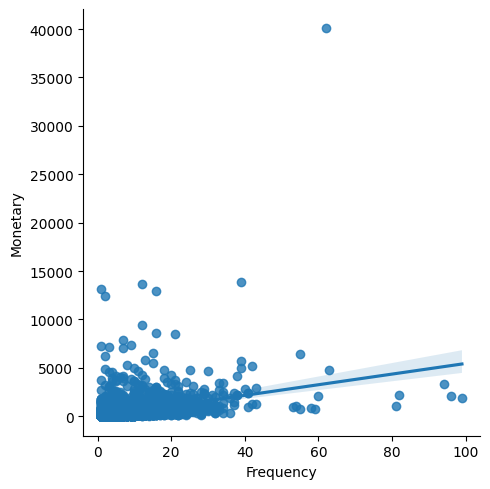

In [ ]:
sns.lmplot(x='Frequency', y='Monetary', data=rfm,fit_reg=True)

Dalam memastikan nilai rendah-tingginya score RFM, dilakukan beberapa perhitungan yang melihatkan klasifikasi berdasarkan quartiles dari data tersebut. pengunaan klasifikasi quartile merupakan cara simple dan pasti dalam menentukan limit dari setiap klasifikasinya. sebagai contoh, jika jumlah transaksi 100 kali dengan perhitungan quartile 25% (0,25) akan menunjukkan 4 kali periode waktu pembelian. semakin tinggi nilai pengkali quartile maka semakin kecil periode pembeliannya. hal yang sama juga berlaku untuk monetary dan berbanding terbalik terhadap perlakuan recency.

In [ ]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,44.0,1.0,10.81
0.50,120.0,1.0,27.26
0.75,242.0,3.0,83.08


In [ ]:
RFMScores= rfm.copy()
#Recency Scoring
def Rscoring(x,p,d):
   if x <= d[p][0.25]:
      return 1
   elif x <= d[p][0.50]:
      return 2
   elif x <= d[p][0.75]:
      return 3
   else:
      return 4
#Frequency and Monetary Scoring
def FMscoring (x,p,d):
   if x <= d[p][0.25]:
      return 4
   elif x <= d[p][0.50]:
      return 3
   elif x <= d[p][0.75]:
      return 2
   else:
      return 1
RFMScores['R']=RFMScores['Recency'].apply(Rscoring, args=('Recency',quantiles))
RFMScores['F']=RFMScores['Frequency'].apply(FMscoring, args=('Frequency',quantiles))
RFMScores['M']=RFMScores['Monetary'].apply(FMscoring, args=('Monetary',quantiles))
RFMScores['RFMgroup']=RFMScores.R.map(str)+RFMScores.F.map(str)+RFMScores.M.map(str)
RFMScores['Score']=RFMScores[['R','F','M']].sum(axis=1)
print(RFMScores.head())

             Recency  Frequency  Monetary  R  F  M RFMgroup  Score
Customer_ID                                                       
1                344          1     16.29  4  4  3      443     11
2                195          2     22.77  3  2  3      323      8
3                334          1     19.08  4  4  3      443     11
4                 54          2     33.29  2  2  2      222      6
5                120          5    248.27  2  1  1      211      4


Lakukan Clustering K-means!

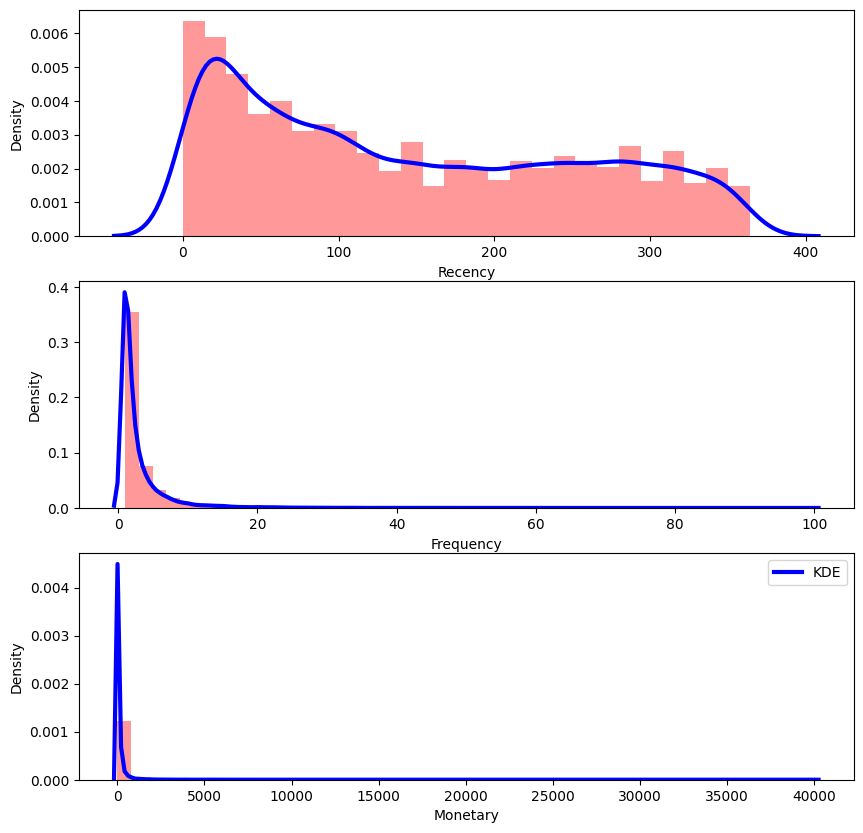

In [ ]:
#Melihat distibusi data hasil RFMScore
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
sns.distplot(rfm['Recency'],kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"r"})
plt.subplot(3,1,2)
sns.distplot(rfm['Frequency'],kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"r"})
plt.subplot(3,1,3)
sns.distplot(rfm['Monetary'],kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"r"})
plt.legend()
plt.show()

In [ ]:
clustering_rfm = rfm[['Recency',"Frequency","Monetary"]].copy()
clustering_rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
1,344,1,16.29
2,195,2,22.77
3,334,1,19.08
4,54,2,33.29
5,120,5,248.27


In [ ]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clustering_rfm)
data_scaled = pd.DataFrame(x_scaled,columns=['Recency','Frequency','Monetary'])
data_scaled

,Recency,Frequency,Monetary
0,0.945055,0.000000,0.000403
1,0.535714,0.010204,0.000565
2,0.917582,0.000000,0.000473
3,0.148352,0.010204,0.000827
4,0.329670,0.040816,0.006192
...,...,...,...
22620,0.219780,0.000000,0.000426
22621,0.041209,0.000000,0.000148
22622,0.027473,0.000000,0.005633
22623,0.887363,0.000000,0.000486


Gunakan ELbow methode untuk menentukan jumlah cluster.

Text(0.5, 1.0, 'Elbow plot for optimal number of clusters')

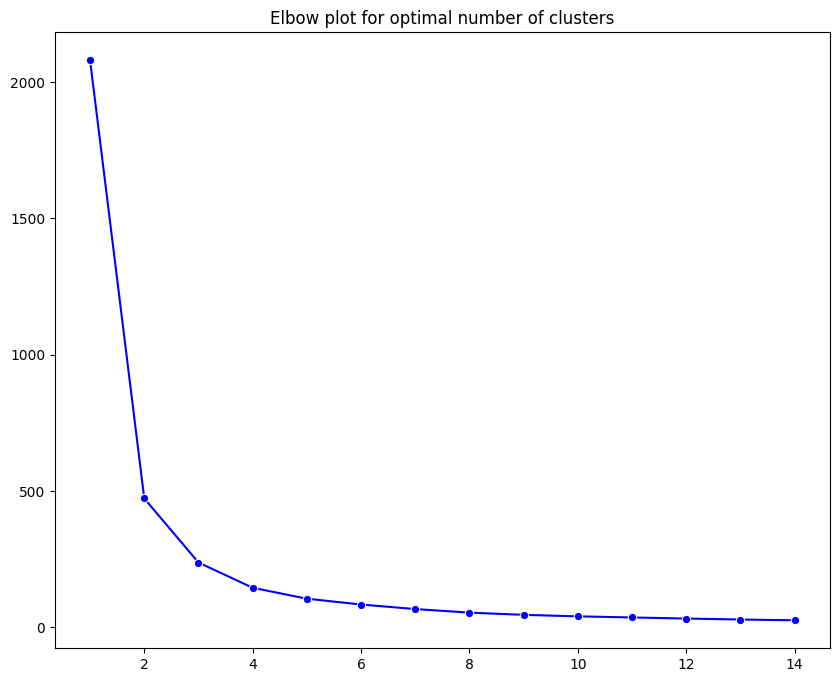

In [ ]:
wscc = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init="k-means++",random_state=0)
    kmeans.fit(data_scaled)
    wscc.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
sns.lineplot(x=range(1,15),y=wscc,marker="o",c='blue')
plt.title("Elbow plot for optimal number of clusters")

In [ ]:
wscc

[2079.4873828519376,
 472.53307031603185,
 237.7312230530182,
 145.1475748339136,
 105.03104518924754,
 83.66531960834106,
 67.00346074839797,
 53.951319179577254,
 45.81547033662692,
 40.3102282840552,
 36.23870820594905,
 32.20188997414574,
 28.67142450142316,
 25.895347016493808]

Berapa cluster yang akan dibentuk dari Elbow methode? buatlah clusternya!

Penentuan jumlah clustering pada gambar disamping ini mengunakan sistem interpretatif personal dengan cara melihat titik yang memulai perbedaan tidak signifikan berubah atau nilai error yang tidak signifikan. Pada kasus ini jumlah clustering idealnya adalah 3 atau 4, dimana pada titik selanjutnya tidak menunjukkan perbedaan yang signifikan. langkah selanjutnya ialah melakukan clustering dengan jumlah cluster 3.

In [ ]:
#Clustering dengan mengunakan Kmeans.
kmeans = KMeans(n_clusters=3, random_state=0,init='k-means++',
                n_init =10,max_iter = 300).fit(data_scaled)
pred = kmeans.predict(data_scaled)
RFMScores['Cluster']=kmeans.labels_
RFMScores.head(10)

,Recency,Frequency,Monetary,R,F,M,RFMgroup,Score,Cluster
Customer_ID,,,,,,,,,
1,344,1,16.29,4,4,3,443,11,1
2,195,2,22.77,3,2,3,323,8,2
3,334,1,19.08,4,4,3,443,11,1
4,54,2,33.29,2,2,2,222,6,0
5,120,5,248.27,2,1,1,211,4,2
6,275,1,25.55,4,4,3,443,11,1
7,235,1,17.84,3,4,3,343,10,1
8,193,1,19.56,3,4,3,343,10,2
9,286,1,15.75,4,4,3,443,11,1


In [ ]:
RFMScores.groupby('Cluster').mean().sort_values('Score',ascending=False)

,Recency,Frequency,Monetary,R,F,M,Score
Cluster,,,,,,,
1,293.578339,1.400000,56.048520,3.909609,3.477036,2.912704,10.299349
2,165.254866,1.927252,72.680872,2.843451,3.014022,2.661003,8.518476
0,44.411686,4.260098,189.559622,1.452845,2.292814,2.163772,5.909431


Bagaimana hasil pengelompokan pelanggan dari analisis yang telah dilakukan?

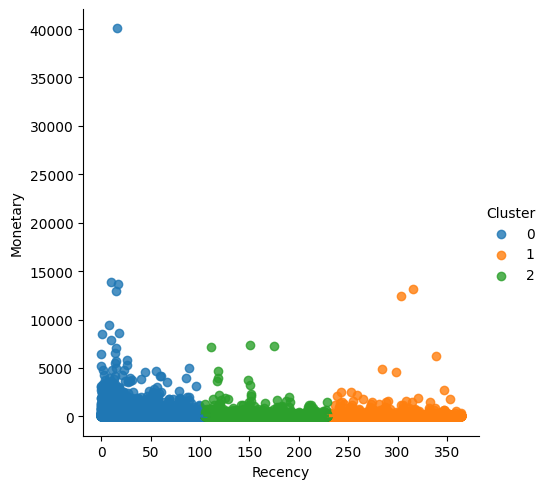

In [ ]:
sns.lmplot(x='Recency', y='Monetary', data=RFMScores, hue='Cluster', fit_reg=True)

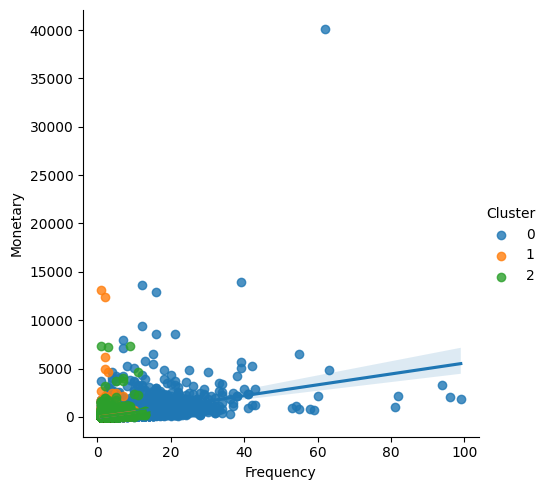

In [ ]:
sns.lmplot(x='Frequency', y='Monetary', data=RFMScores, hue='Cluster')

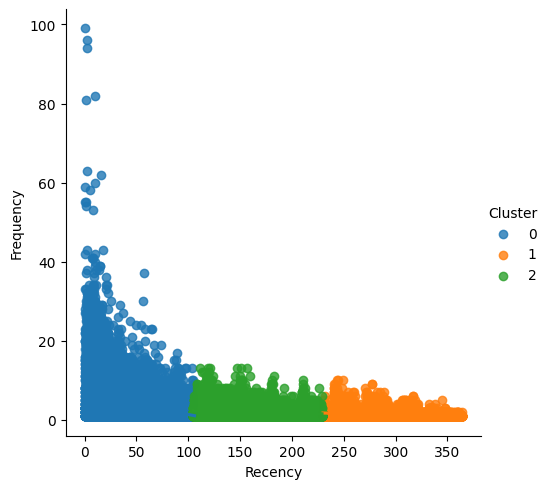

In [ ]:
sns.lmplot(x='Recency', y='Frequency', data=RFMScores, hue='Cluster', fit_reg=True)

Dari hasil analisis, diperoleh 3 cluster yaitu cluster 0, cluster 1, dan cluster 2. Jika dilihat, cluster 0 memiliki recency tinggi dengan frequency rendah dan monetary rendah. Artinya, pelanggan kelompok ini sudah lama dan jarang melakukan transaksi sehingga uang yang dikeluarkan pelanggan sedikit. Cluster 1 memiliki recency paling kecil dengan frequency dan monetary paling tinggi. Artinya, pelanggan kelompok ini masih sering dan paling sering melakukan transaksi sehingga uang yang dikeluarkan pelanggan sangat besar. Sedangkan cluster 2, memiliki recency, frequency dan monetary menangah diantara cluster 0 dan 1. Artinya, pelanggan kelompok ini pelanggan yang tidak jarang dan tidak sering pula melakukan transaksi dengan uang yang dikeluarkan tidak banyak dan tidak sedikit pula. Sehingga, dapat dikatakan cluster 0 adalah pelanggan silver, cluster 1 pelanggan platinum dan cluster 2 pelanggan gold.